# Text Generation model

## Import the libraries


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import torch
import torch.nn as nn
import torch.nn.functional as F

from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize
from torch.utils.data import Dataset, DataLoader
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

## Load the dataset

In [4]:
filename = "Harry_Potter.txt"
raw_text = open(filename, 'r', encoding='utf-8').read()
raw_text = raw_text.lower()

chars = sorted(list(set(raw_text)))
char_to_int = dict((c, i) for i, c in enumerate(chars))

n_chars = len(raw_text)
n_vocab = len(chars)
print("Total Characters: ", n_chars)
print("Total Vocab: ", n_vocab)

Total Characters:  439742
Total Vocab:  53


## Meta Features

In [6]:
sentences = sent_tokenize(raw_text)

train = pd.DataFrame(sentences, columns=['Sentence'])

In [7]:
train.sample(5)

,Sentence
2572,dumbledore's twinkling eyes flashed in the dir...
3337,"""i'm going to show you what the bludgers do,"" ..."
4474,ron snapped.
1444,"a lot of green smoke came billowing out, and\n..."
2137,"i've been asking around, and i hope i'm in gry..."


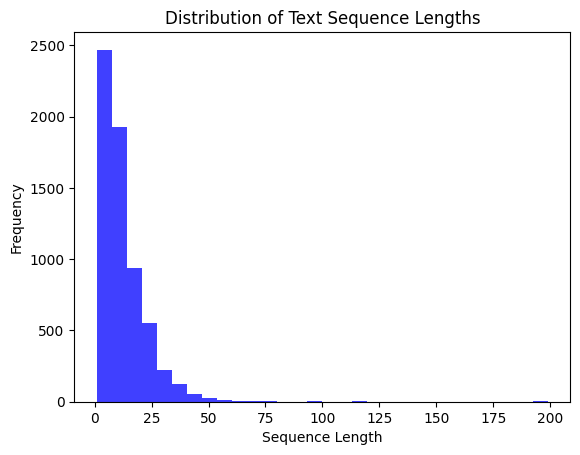

In [8]:
sequence_lengths = train['Sentence'].apply(lambda x: len(x.split()))

plt.hist(sequence_lengths, bins=30, alpha=0.75, color='blue')
plt.title('Distribution of Text Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.show()



In [9]:
train['Sentence'][71]

'even muggles like yourself should be celebrating, this happy,\nhappy day!"'

# LSTM

Long Short-Term Memory (LSTM) is a type of Recurrent Neural Network (RNN) that is capable of learning long-term dependencies. It is widely used in various applications, including text generation.

## Embeddings and Text Cleaning

In [80]:
def clean_text(text):
    text = re.sub(r'\W+|\d+|_', ' ', text.lower())
    return text

def tokenize_lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stopwords.words('english')]
    return tokens

def create_dictionary(tokens):
    unique_tokens = list(set(tokens))
    token_to_int = {token: i for i, token in enumerate(unique_tokens)}
    int_to_token = {i: token for i, token in enumerate(unique_tokens)}
    return token_to_int, int_to_token

class TextDataset(Dataset):
    def __init__(self, tokens, token_to_int, seq_length):
        self.tokens = tokens
        self.token_to_int = token_to_int
        self.seq_length = seq_length

    def __len__(self):
        return len(self.tokens) // self.seq_length

    def __getitem__(self, idx):
        start_idx = idx * self.seq_length
        end_idx = start_idx + self.seq_length
        input_seq = [self.token_to_int[token] for token in self.tokens[start_idx:end_idx]]
        target_seq = [self.token_to_int[token] for token in self.tokens[start_idx+1:end_idx+1]]
        return torch.tensor(input_seq), torch.tensor(target_seq)

filename = "Harry_Potter.txt"
text = open(filename, 'r', encoding='utf-8').read()
cleaned_text = clean_text(text)
tokens = tokenize_lemmatize(cleaned_text)
token_to_int, int_to_token = create_dictionary(tokens)
seq_length = 26
dataset = TextDataset(tokens, token_to_int, seq_length)

In [104]:
if '<unk>' not in token_to_int:
    token_to_int['<unk>'] = len(token_to_int)
    int_to_token[len(int_to_token)] = '<unk>'

In [81]:
len(dataset.tokens)

40770

In [82]:
batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Model

In [133]:
class LSTMGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, dropout=0.5):
        super(LSTMGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        embedded = self.embedding(x)
        lstm_out, hidden = self.lstm(embedded, hidden)
        out = self.fc(lstm_out)
        return out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        hidden = (weight.new(self.lstm.num_layers, batch_size, self.lstm.hidden_size).zero_().to(device),
                  weight.new(self.lstm.num_layers, batch_size, self.lstm.hidden_size).zero_().to(device))
        return hidden

In [134]:
def train(model, dataloader, epochs, learning_rate):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()

    losses = []

    for epoch in range(epochs):
        hidden = model.init_hidden(batch_size)
        epoch_loss = 0
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            hidden = tuple([each.data for each in hidden])
            model.zero_grad()
            output, hidden = model(inputs, hidden)
            loss = criterion(output.view(-1, vocab_size), targets.view(-1))
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(dataloader)
        losses.append(epoch_loss)

        print(f'Epoch: {epoch+1}/{epochs}, Loss: {epoch_loss}')

    plt.plot(losses)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

Epoch: 1/250, Loss: 7.603839290385344
Epoch: 2/250, Loss: 7.319860633538694
Epoch: 3/250, Loss: 7.304159378518864
Epoch: 4/250, Loss: 7.301517019466478
Epoch: 5/250, Loss: 7.295626873872718
Epoch: 6/250, Loss: 7.2944023949759345
Epoch: 7/250, Loss: 7.289388598227988
Epoch: 8/250, Loss: 7.287231094983159
Epoch: 9/250, Loss: 7.2861006989771
Epoch: 10/250, Loss: 7.2840374537876675
Epoch: 11/250, Loss: 7.281503365964306
Epoch: 12/250, Loss: 7.280299439722178
Epoch: 13/250, Loss: 7.279068888450156
Epoch: 14/250, Loss: 7.280221326010568
Epoch: 15/250, Loss: 7.27685546875
Epoch: 16/250, Loss: 7.257076652682557
Epoch: 17/250, Loss: 7.216392935538779
Epoch: 18/250, Loss: 7.1672636732763175
Epoch: 19/250, Loss: 7.093232125652079
Epoch: 20/250, Loss: 6.99840496024307
Epoch: 21/250, Loss: 6.897185208846111
Epoch: 22/250, Loss: 6.78420487228705
Epoch: 23/250, Loss: 6.677703633600352
Epoch: 24/250, Loss: 6.581617890572061
Epoch: 25/250, Loss: 6.497300002039696
Epoch: 26/250, Loss: 6.411247749717868


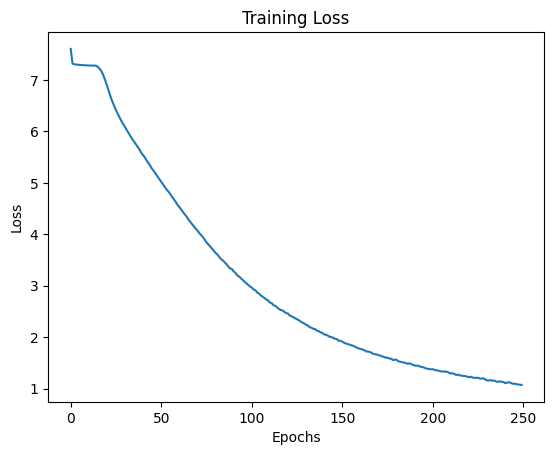

In [141]:
embedding_dim = 256
hidden_dim = 512
num_layers = 4
epochs = 250
learning_rate = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vocab_size = len(token_to_int)
model = LSTMGenerator(vocab_size, embedding_dim, hidden_dim, num_layers).to(device)
train(model, dataloader, epochs, learning_rate)

## Generating the text

In [197]:
def generate_text(model, start_word, token_to_int, int_to_token, length=20, temperature=1.0, top_k=10):
    model.eval()
    generated_text = [start_word]
    current_word = start_word

    with torch.no_grad():
        for _ in range(length):
            input_word = torch.tensor([token_to_int.get(current_word, token_to_int['<unk>'])]).to(device)
            input_word = input_word.unsqueeze(0)

            output, hidden = model(input_word, model.init_hidden(1))
            output = output.squeeze(0)

            output = output / temperature

            output_probs = F.softmax(output, dim=-1)

            top_p, top_i = output_probs.topk(top_k)

            top_p_np = top_p.cpu().numpy().squeeze()
            top_i_np = top_i.cpu().numpy().squeeze()

            next_word_idx = np.random.choice(top_i_np, p=top_p_np/top_p_np.sum())
            next_word = int_to_token.get(next_word_idx, '<unk>')


            generated_text.append(next_word)


            current_word = next_word

    return ' '.join(generated_text)

In [213]:
start_word = 'first'
generated_text = generate_text(model, start_word, token_to_int, int_to_token)
print(generated_text)

first time harry potter harry entered back platform nasty darted right harry know said hermione entered hair clambered back head thought


### It can be seen that the model has learned to handle sequences, but it still looks quite crude. The results can be improved with the following points:

+ Adding more data
+ Fine Tuning the network architecture
+ Fine Tuning the network parameters

# GPT2

GPT-2 is a transformers model pretrained on a very large corpus of English data in a self-supervised fashion. This means it was pretrained on the raw texts only, with no humans labelling them in any way (which is why it can use lots of publicly available data) with an automatic process to generate inputs and labels from those texts. More precisely, it was trained to guess the next word in sentences. Perfect for us.

In [2]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import GPT2Tokenizer, GPT2LMHeadModel, AdamW
from tqdm import tqdm

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2')

class TextDataset(Dataset):
    def __init__(self, tokenizer, file_path, block_size):
        with open(file_path, 'r', encoding='utf-8') as f:
            text = f.read()
        self.examples = []
        self.tokenizer = tokenizer
        self.block_size = block_size

        tokenized_text = tokenizer.encode(text)
        for i in range(0, len(tokenized_text) - block_size + 1, block_size):
            self.examples.append(tokenizer.build_inputs_with_special_tokens(tokenized_text[i: i + block_size]))

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):
        return torch.tensor(self.examples[i])

dataset = TextDataset(tokenizer, 'Harry_Potter.txt', block_size=128)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

optimizer = AdamW(model.parameters(), lr=5e-5)

model.train()
for epoch in range(3):
    for batch in tqdm(dataloader):
        optimizer.zero_grad()
        input_ids = batch.to(model.device)
        outputs = model(input_ids, labels=input_ids)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

model.save_pretrained('./fine-tuned-gpt2')

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (116725 > 1024). Running this sequence through the model will result in indexing errors
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
100%|██████████| 911/911 [1:00:46<00:00,  4.00s/it]


In [43]:
prompt = "Potter"
inputs = tokenizer.encode(prompt, return_tensors='pt')
outputs = model.generate(inputs, max_length=30, num_return_sequences=1)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

print(generated_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Potter, you're not going to be able to
get the Stone, you'll be in trouble."

"I'm not going to


Wow. You can see that it only took the model 3 iterations to generate good text. Impressive. But it can be made even better:
+ Add special tokens
+ Increase the number of epochs